In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, time, cv2

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

VOL = '/mnt/data1/stock/misc/canine'
DSIZE = (32, 32)
NPY_IMAGE_PATH = os.path.join(VOL, f'images_{DSIZE[0]}x{DSIZE[1]}.npy')
NPY_LABEL_PATH = os.path.join(VOL, f'labels.npy')

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
# !nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Data Loader

In [5]:
# (optional) save the data to an np.array 

# join all csv's to a single dataframe
data_labels = glob.glob(os.path.join(VOL, 'labels/*'))

li = []
for filename in data_labels:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['breed'] = filename.split('-')[-1][:-4]
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)

X = np.zeros((len(df), DSIZE[0], DSIZE[1], 3))
T = np.zeros((len(df), 1), dtype=object)

f = FloatProgress(min=0, max=len(df))
display(f)

for i, row in df.iterrows():
    im_path = glob.glob(os.path.join(VOL, f"Images/*/{row['id']}"))[0]
    im = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB) # BGR -> RGB
    im = cv2.resize(im, DSIZE)
    X[i] = im
    T[i] = row['label']
    
    f.value += 1
    
with open(NPY_IMAGE_PATH, 'wb') as f:
    np.save(f, X)

with open(NPY_LABEL_PATH, 'wb') as f:
    np.save(f, T)

FloatProgress(value=0.0, max=20578.0)

In [162]:
def load_data(npy_image_path, npy_label_path, normalize=True):
    """Assumes an np.array for the images X and labels T have been saved.
    """
    with open(npy_image_path, 'rb') as f:
        X = np.load(f, allow_pickle=True)
    
    if normalize:
        X /= 255.0
        
    with open(npy_label_path, 'rb') as f:
        T = np.load(f, allow_pickle=True)
    
    labels, T = np.unique(T, return_inverse=True)
    T = T.reshape((-1,1))
    
    return X, T, labels


def partition_data(X, T, partition=(0.6,0.2,0.2), shuffle=False):
    """Load the data and parition it to training, validation (optional), and test set 
    according to class proportions.
    ---
    params:
    X : np.array
    T : np.array
    partition : list
        Of the form (train, val, test) or (train, test)
    shuffle : bool
        Shuffle the data after partitioning
    ---
    return: 
    Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest where validation is optional
    
    """
    assert sum(partition) == 1, 'partion must sum to 1.0, e.g. (0.6, 0.2, 0.2) or (0.8, 0.2)'
    
    trainFraction = partition[0]
    
    if len(partition) == 2:
        validateFraction = 0
        testFraction = partition[1]
    if len(partition) == 3:
        validateFraction = partition[1]
        testFraction = partition[2]
        
    rowIndices = np.arange(X.shape[0])
    
    classes = np.unique(T)
    trainIndices = []
    validateIndices = []
    testIndices = []
    for c in classes:
        # row indices for class c
        cRows = np.where(T[rowIndices,:] == c)[0]
        # collect row indices for class c for each partition
        n = len(cRows)
        nTrain = round(trainFraction * n)
        nValidate = round(validateFraction * n)
        nTest = round(testFraction * n)
        
        if nTrain + nValidate + nTest > n:
            nTest = n - nTrain - nValidate
        trainIndices += rowIndices[cRows[:nTrain]].tolist()
        
        if nValidate > 0:
            validateIndices += rowIndices[cRows[nTrain:nTrain+nValidate]].tolist()
        testIndices += rowIndices[cRows[nTrain+nValidate:nTrain+nValidate+nTest]].tolist()
    
    if shuffle:
        np.random.shuffle(trainIndices)
        if nValidate > 0:
            np.random.shuffle(validateIndices)
        np.random.shuffle(testIndices)
        
    Xtrain = X[trainIndices,:]
    Ttrain = T[trainIndices,:]
    if nValidate > 0:
        Xvalidate = X[validateIndices,:]
        Tvalidate = T[validateIndices,:]
    Xtest = X[testIndices,:]
    Ttest = T[testIndices,:]
        
    if nValidate > 0:
        return Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest
    else:
        return Xtrain,Ttrain,Xtest,Ttest

In [163]:
X, T, class_labels = load_data(NPY_IMAGE_PATH, NPY_LABEL_PATH, normalize=True)
Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest = partition_data(X, T, partition=(0.6,0.2,0.2), shuffle=True)

print(Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape)

(12347, 32, 32, 3) (12347, 1) (4116, 32, 32, 3) (4116, 1) (4114, 32, 32, 3) (4114, 1)


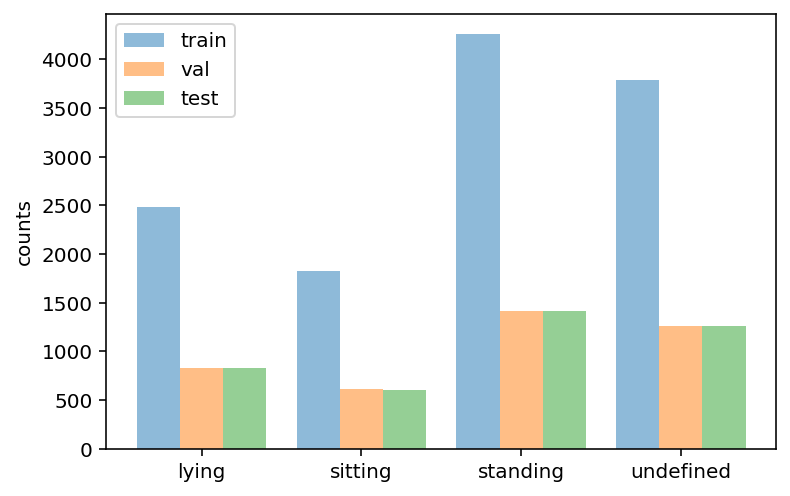

In [164]:
ind = np.arange(len(class_labels))
width = 0.27 # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))

_, counts = np.unique(Ttrain, return_counts=True)
rects1 = ax.bar(ind, counts, width, alpha=0.5)
_, counts = np.unique(Tvalidate, return_counts=True)
rects2 = ax.bar(ind+width, counts, width, alpha=0.5)
_, counts = np.unique(Ttest, return_counts=True)
rects3 = ax.bar(ind+width*2, counts, width, alpha=0.5)

ax.set_ylabel('counts')
ax.set_xticks(ind+width)
ax.set_xticklabels(class_labels)
ax.legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

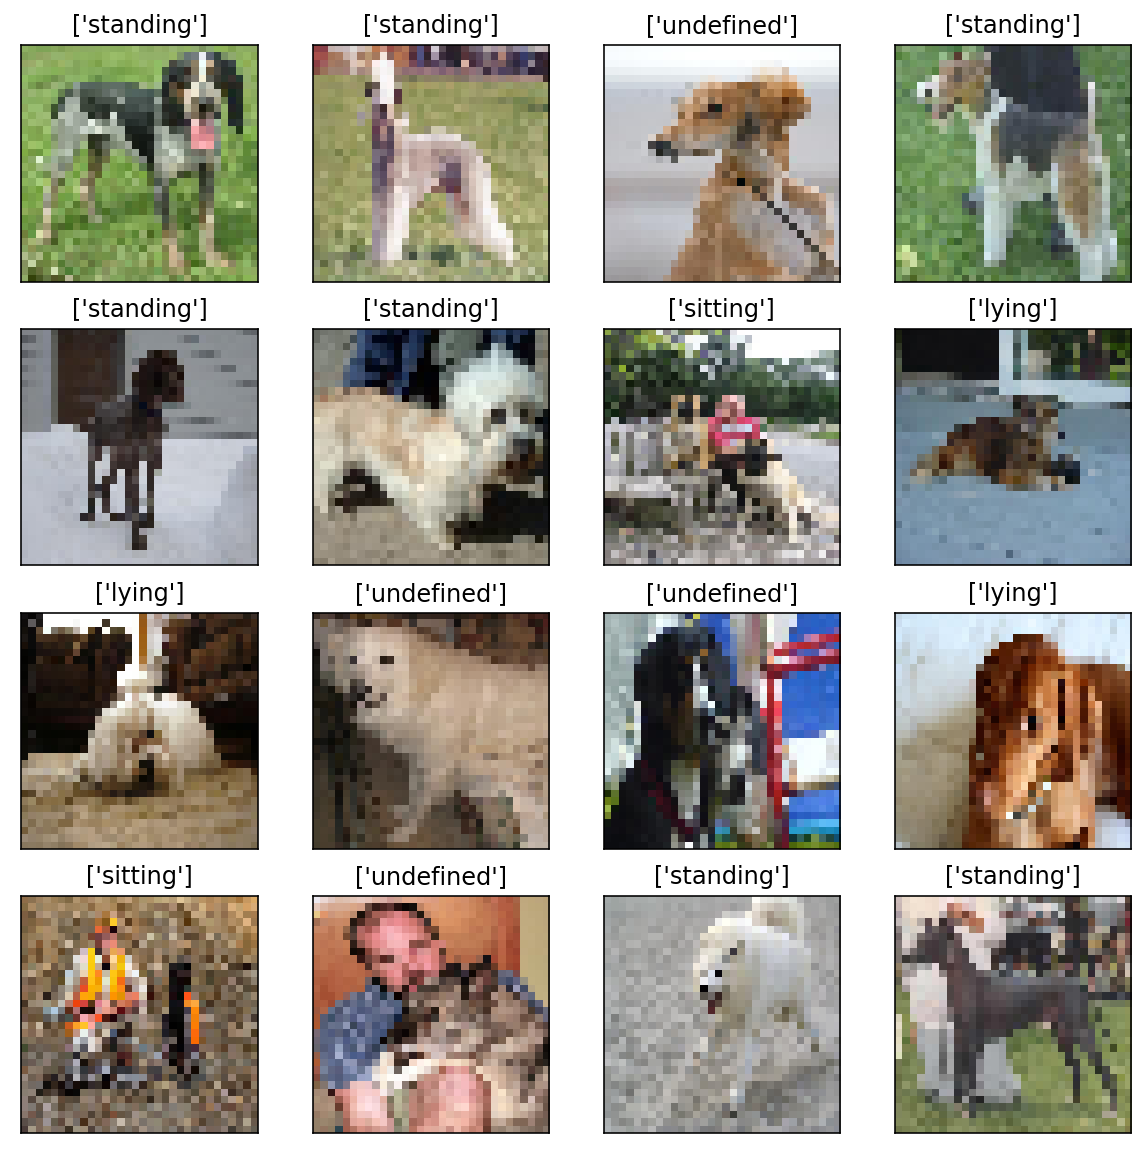

In [165]:
h, w = 4, 4
fig, axs = plt.subplots(h, w, figsize=(10, 10))
axs = axs.ravel()
for i in range(h*w):
    axs[i].imshow(Xtrain[i])
    axs[i].set_title(class_labels[Ttrain[i]])
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

# Basic Model

In [155]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs = axs.ravel()
    
    axs[0].plot(history['accuracy'], label='train')
    axs[0].plot(history['val_accuracy'], label = 'val')
    axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim([0.4, 1])
    axs[0].legend(loc='lower right')
    
    axs[1].plot(history['loss'], label='train')
    axs[1].plot(history['val_loss'], label = 'val')
    axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('Loss')

In [153]:
tf.keras.backend.clear_session()

epochs = 30
batch_size = 128
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
n_units_in_conv_layers = [32, 64, 128]
kernels_size_and_stride = [(3, 1)]*len(n_units_in_conv_layers)

X = Z = tf.keras.Input(shape=Xtrain.shape[1:])
for (kernel, stride), units in zip(kernels_size_and_stride, n_units_in_conv_layers):
    Z = tf.keras.layers.Conv2D(
        units, kernel_size=kernel, strides=stride, padding='same')(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation('relu')(Z)
    Z = tf.keras.layers.MaxPooling2D(pool_size=2)(Z)
    Z = tf.keras.layers.Dropout(0.20)(Z)

Z = tf.keras.layers.Dense(128, activation='relu')(tf.keras.layers.Flatten()(Z))
Y = tf.keras.layers.Dense(len(np.unique(Ttrain)), activation='softmax')(Z)

model = tf.keras.Model(inputs=X, outputs=Y)

model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)]

start_t = time.time()
history = model.fit(Xtrain, Ttrain, verbose=2,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(Xvalidate, Tvalidate),
                    callbacks=callbacks).history

print(f'Finished in {time.time() - start_t:.3f} seconds.')

Epoch 1/30
97/97 - 1s - loss: 1.4601 - accuracy: 0.3755 - val_loss: 1.3610 - val_accuracy: 0.3622
Epoch 2/30
97/97 - 0s - loss: 1.2405 - accuracy: 0.4531 - val_loss: 1.3327 - val_accuracy: 0.3960
Epoch 3/30
97/97 - 1s - loss: 1.1775 - accuracy: 0.4908 - val_loss: 1.2633 - val_accuracy: 0.4266
Epoch 4/30
97/97 - 0s - loss: 1.1154 - accuracy: 0.5273 - val_loss: 1.1743 - val_accuracy: 0.5046
Epoch 5/30
97/97 - 1s - loss: 1.0753 - accuracy: 0.5477 - val_loss: 1.0977 - val_accuracy: 0.5408
Epoch 6/30
97/97 - 1s - loss: 1.0540 - accuracy: 0.5585 - val_loss: 1.0787 - val_accuracy: 0.5423
Epoch 7/30
97/97 - 1s - loss: 1.0210 - accuracy: 0.5796 - val_loss: 1.0422 - val_accuracy: 0.5773
Epoch 8/30
97/97 - 1s - loss: 1.0151 - accuracy: 0.5834 - val_loss: 1.1065 - val_accuracy: 0.5476
Epoch 9/30
97/97 - 1s - loss: 0.9860 - accuracy: 0.5937 - val_loss: 1.0402 - val_accuracy: 0.5758
Epoch 10/30
97/97 - 1s - loss: 0.9642 - accuracy: 0.6093 - val_loss: 1.0483 - val_accuracy: 0.5673
Epoch 11/30
97/97 -

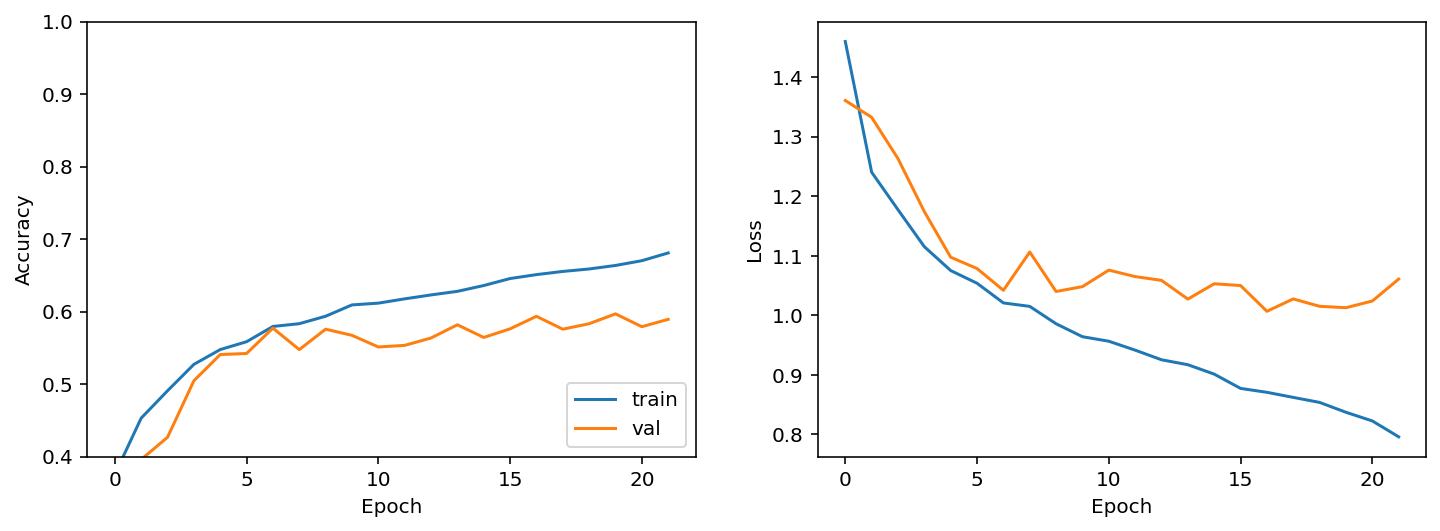

In [156]:
plot_history(history)

In [157]:
model.evaluate(Xtest, Ttest)

129/129 [==============================] - 7s 56ms/step - loss: 1.0459 - accuracy: 0.5970


[1.0459085702896118, 0.5969858765602112]